In [1]:
# To make sure we can import h5utils.py from the notebooks folder
import sys
sys.path.append('../')

In [2]:
import os
import npyx
import h5py
import copy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import utils.h5_utils as h5
import utils.datasets as datasets
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pyro
import pyro.distributions as dist

from sklearn.model_selection import LeaveOneOut

import optuna

from tqdm.auto import tqdm
from pathlib import Path
from visdom import Visdom
import pyro.optim as optim
from pyro.optim import Adam, RMSprop
from torchvision import transforms
from pyro.contrib.examples.util import print_and_log
from pyro_VAE.pyro_utils.custom_mlp import MLP, Exp

from pyro.infer import (
    SVI,
    JitTrace_ELBO,
    JitTraceEnum_ELBO,
    Trace_ELBO,
    TraceEnum_ELBO,
    config_enumerate,
)

plt.style.use("seaborn-notebook")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

npyx version 2.5.2 imported.


/home/npyx/miniconda3/envs/npyx/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Seeds, constants, data import

In [3]:
# Path to the current hdf5 dataset
PATH = os.path.dirname(os.path.abspath(""))
home = str(Path.home())
DATA_PATH = home + '/Desktop/fede_dataset.h5'

# To convert text labels to numbers
LABELLING = {'PkC_cs': 5, 'PkC_ss': 4, 'MFB':3, 'MLI':2, 'GoC':1, 'GrC':0, 'unlabelled':-1}

# To do the inverse
CORRESPONDENCE = {5: 'PkC_cs', 4: 'PkC_ss', 3 : 'MFB', 2: 'MLI', 1:'GoC', 0:'GrC', -1:'unlabelled'}

CENTRAL_RANGE = 60

N_CHANNELS = 10

TEST_SIZE = 0

BATCH_SIZE = 30

ACG_LEN = 100

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

N_CLASSES = 6

SEED = 1234

In [4]:
h5.set_seed(SEED, seed_torch=True)

Random seed 1234 has been set.


1234

In [5]:
dataset = h5.NeuronsDataset(DATA_PATH, normalise = False)

Reading dataset:   0%|          | 0/1213 [00:00<?, ?it/s]

954 neurons loaded, of which labelled: 77 
259 neurons discarded, of which labelled: 7. More details at the 'discarded_df' attribute.


In [6]:
def mask_dataset(input_dataset: h5.NeuronsDataset, mask_out):
    
    dataset = copy.copy(input_dataset)
    test_point = copy.copy(input_dataset)
    
    dataset.wf = dataset.wf[~mask_out]
    dataset.acg = dataset.acg[~mask_out]
    dataset.spikes_list = np.array(dataset.spikes_list, dtype='object')[~mask_out].tolist()
    dataset.targets = dataset.targets[~mask_out]
    
    test_point.wf = test_point.wf[mask_out]
    test_point.acg = test_point.acg[mask_out]
    test_point.spikes_list = np.array(test_point.spikes_list, dtype='object')[mask_out].tolist()
    test_point.targets = test_point.targets[mask_out]
    
    return dataset, test_point

In [9]:
# Choosing the scaling and the type of dataset we want (full, acg or wf)
dataset.min_max_scale()
dataset.make_full_dataset()

full_dataset = dataset.full_dataset

In [10]:
# Creating a dataframe in case we need it for plotting
df = pd.DataFrame(
    np.concatenate((dataset.targets[:, None], dataset.wf, np.array(dataset.info)[:, None]), axis=1),
).rename(columns={0: "label", 601: "dataset"})

df['label'].apply(float).apply(int).replace(CORRESPONDENCE).value_counts()

unlabelled    877
GoC            25
PkC_ss         21
PkC_cs         11
MFB             9
GrC             6
MLI             5
Name: label, dtype: int64

In [11]:
composed = datasets.CustomCompose(
    [
        datasets.VerticalReflection(p=0.3),
        datasets.SwapChannels(p=0.5),
        datasets.AddSpikes(p=0.3, max_addition=0.15),
        datasets.DeleteSpikes(p=0.3, deletion_prob=0.1),
        datasets.MoveSpikes(p=0.2, max_shift=10),
        datasets.GaussianNoise(p=0.2),
        datasets.ConstantShift(p=0.3),
    ]
)

In [12]:
class SSVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks) and models & guides needed to train a
    semi-supervised variational auto-encoder on the MNIST image dataset

    :param output_size: size of the tensor representing the class label (10 for MNIST since
                        we represent the class labels as a one-hot vector with 10 components)
    :param input_size: size of the tensor representing the image (28*28 = 784 for our MNIST dataset
                       since we flatten the images and scale the pixels to be in [0,1])
    :param z_dim: size of the tensor representing the latent random variable z
                  (handwriting style for our MNIST dataset)
    :param hidden_layers: a tuple (or list) of MLP layers to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """

    # TODO Mind these default parameters!!
    def __init__(
        self,
        output_size=N_CLASSES,
        input_size=N_CHANNELS * CENTRAL_RANGE + ACG_LEN,
        z_dim=50,
        hidden_layers=[500,],
        hidden_layers_classifier = None,
        config_enum=None,
        use_cuda=False,
        aux_loss_multiplier=None,
        non_linearity=None,
    ):

        super().__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == "parallel"
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier
        self.non_linearity = non_linearity if non_linearity is not None else nn.ReLU
        self.hidden_layers_classifier = hidden_layers if hidden_layers_classifier is None else hidden_layers_classifier

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):

        z_dim = self.z_dim
        hidden_sizes = self.hidden_layers
        hidden_sizes_classifier = self.hidden_layers_classifier

        # define the neural networks used later in the model and the guide.
        # these networks are MLPs (multi-layered perceptrons or simple feed-forward networks)
        # where the provided activation parameter is used on every linear layer except
        # for the output layer where we use the provided output_activation parameter
        self.encoder_y = MLP(
            [self.input_size] + hidden_sizes_classifier + [self.output_size],
            activation=self.non_linearity,
            output_activation=nn.Softmax,
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )

        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
        self.encoder_z = MLP(
            [self.input_size + self.output_size] + hidden_sizes + [[z_dim, z_dim]],
            activation=self.non_linearity,
            output_activation=[None, Exp],
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )
        #! Change here for Gaussian output
        self.decoder = MLP(
            [z_dim + self.output_size]
            + hidden_sizes[::-1]
            + [[self.input_size, self.input_size]],
            activation=self.non_linearity,
            output_activation=[None, Exp],
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )

        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # handwriting style (latent)
        p(y|x) = categorical(I/10.)     # which digit (semi-supervised)
        p(x|y,z) = bernoulli(loc(y,z))   # an image
        loc is given by a neural network  `decoder`

        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        batch_size = xs.size(0)
        options = dict(dtype=xs.dtype, device=xs.device)
        with pyro.plate("data"):

            # sample the style from the constant prior distribution
            prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, **options)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which cell) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = torch.ones(batch_size, self.output_size, **options) / (
                1.0 * self.output_size
            )
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)

            # Finally, score the observed data (x) using the style (z) and
            # the class label y (which cell) against the
            # parametrized distribution p(x|y,z) = Normal(decoder(y,z))
            # where `decoder` is a neural network.
            loc, scale = self.decoder.forward([zs, ys])
            #! Change also here for Normal!
            pyro.sample(
                "x", dist.Normal(loc, scale, validate_args=False).to_event(1), obs=xs
            )
            # return the loc and scale so we can visualize it later
            return loc, scale

    def guide(self, xs, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = categorical(alpha(x))              # infer digit from an image
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer handwriting style from an image and the digit
        loc, scale are given by a neural network `encoder_z`
        alpha is given by a neural network `encoder_y`

        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # if the class label (the digit) is not supervised, sample
            # (and score) the digit with the variational distribution
            # q(y|x) = categorical(alpha(x))
            if ys is None:
                alpha = self.encoder_y.forward(xs)
                ys = pyro.sample("y", dist.OneHotCategorical(alpha))

            # sample (and score) the latent handwriting-style with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z.forward([xs, ys])
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    def classifier(self, xs):
        """
        classify an image (or a batch of images)

        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        # use the trained model q(y|x) = categorical(alpha(x))
        # compute all class probabilities for the image(s)
        alpha = self.encoder_y.forward(xs)

        # get the index (digit) that corresponds to
        # the maximum predicted class probability
        res, ind = torch.topk(alpha, 1)

        # convert the digit(s) to one-hot tensor(s)
        ys = torch.zeros_like(alpha).scatter_(1, ind, 1.0)
        return ys

    def model_classify(self, xs, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                alpha = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.OneHotCategorical(alpha), obs=ys)

    def guide_classify(self, xs, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass

In [13]:
def run_inference_for_epoch(data_loaders, losses, periodic_interval_batches, scheduler = None):
    """
    runs the inference algorithm for an epoch
    returns the values of all losses separately on supervised and unsupervised parts
    """
    num_losses = len(losses)

    # compute number of batches for an epoch
    sup_batches = len(data_loaders["sup"])
    unsup_batches = len(data_loaders["unsup"])
    batches_per_epoch = sup_batches + unsup_batches

    # initialize variables to store loss values
    epoch_losses_sup = [0.0] * num_losses
    epoch_losses_unsup = [0.0] * num_losses

    # setup the iterators for training data loaders
    sup_iter = iter(data_loaders["sup"])
    unsup_iter = iter(data_loaders["unsup"])

    # count the number of supervised batches seen in this epoch
    ctr_sup = 0
    for i in range(batches_per_epoch):

        # whether this batch is supervised or not
        is_supervised = (i % periodic_interval_batches == 1) and ctr_sup < sup_batches

        # extract the corresponding batch
        if is_supervised:
            (xs, ys) = next(sup_iter)
            ctr_sup += 1
        else:
            (xs, ys) = next(unsup_iter)
        # run the inference for each loss with supervised or un-supervised
        # data as arguments
        for loss_id in range(num_losses):
            if is_supervised:
                new_loss = losses[loss_id].step(xs, ys)
                epoch_losses_sup[loss_id] += new_loss
            else:
                new_loss = losses[loss_id].step(xs)
                epoch_losses_unsup[loss_id] += new_loss
    
    if scheduler is not None:
        scheduler.step()
    # return the values of all losses
    return epoch_losses_sup, epoch_losses_unsup

In [14]:
def get_accuracy(data_loader, classifier_fn, batch_size):
    """
    compute the accuracy over the supervised training set or the testing set
    """
    with torch.no_grad():
        predictions, actuals = [], []

        # use the appropriate data loader
        for (xs, ys) in data_loader:
            # use classification function to compute all predictions for each batch
            predictions.append(classifier_fn(xs))
            actuals.append(ys)

        # compute the number of accurate predictions
        accurate_preds = 0
        for pred, act in zip(predictions, actuals):
            for i in range(pred.size(0)):
                v = torch.sum(pred[i] == act[i])
                accurate_preds += v.item() == N_CLASSES

        # calculate the accuracy between 0 and 1
        accuracy = (accurate_preds * 1.0) / (len(predictions) * batch_size)
    return accuracy


In [15]:
JIT = False
SEED = 1234
VISUALIZE = False
D_LATENT = 50
ETA = 1e-3
BETA = 0.9
CUDA = False
LOG = "./tmp.log"
N_SUPERVISED = 24
EPOCHS = 610
AUX_LOSS = True
INPUT_SIZE = N_CHANNELS * CENTRAL_RANGE + ACG_LEN
OUTPUT_SIZE = N_CLASSES
USE_BEST = True

In [16]:
PATH

'/home/npyx/Dropbox/celltypes-classification'

In [17]:
if USE_BEST:
    best_trials = optuna.load_study(
            "SSVAE_v3", f"sqlite:///{PATH}/SSVAE_v3.db"
        ).best_trials
    params = best_trials[6].params

In [18]:
best_trials[0].values

[0.6296296296296297, 0.3055555555555556]

In [19]:
best_trials[1].values

[0.4027777777777778, 0.9166666666666666]

In [20]:
best_trials[2].values

[0.3333333333333333, 1.0]

In [24]:
best_trials[6].values

[0.5833333333333334, 0.8]

In [25]:
params

{'acg_lr': 0.00496835069560119,
 'aux_multiplier': 41,
 'batch_size': 15,
 'd_latent': 7,
 'hidden_units_class_l1': 54,
 'hidden_units_l1': 65,
 'n_layers_classifier': 1,
 'n_layers_vae': 1,
 'non_linearity': 'tanh',
 'optimizer': 'RMSprop'}

In [26]:
h5.set_seed(SEED)

# Set up encoder and decoder variables

D_LATENT = params["d_latent"]
optimizer_name = params["optimizer"]
ETA = params["acg_lr"]
NON_LINEARITY = params["non_linearity"]
AUX_MULTIPLIER = params["aux_multiplier"]
BATCH_SIZE = params["batch_size"]

N_LAYERS_VAE = params["n_layers_vae"]
if N_LAYERS_VAE == 1:
    hidden_units_1 = params["hidden_units_l1"]
    HIDDEN_LAYERS = [
        hidden_units_1,
    ]

elif N_LAYERS_VAE == 2:
    hidden_units_1 = params["hidden_units_l1"]
    hidden_units_2 = params["hidden_units_l2"]
    HIDDEN_LAYERS = [hidden_units_1, hidden_units_2]

# Set up classifier layers
N_LAYERS_CLASSIFIER = params["n_layers_classifier"]
if N_LAYERS_CLASSIFIER == 1:
    hidden_units_1_class = params["hidden_units_class_l1"]
    HIDDEN_LAYERS_CLASSIFIER = [
        hidden_units_1_class,
    ]

elif N_LAYERS_CLASSIFIER == 2:
    hidden_units_1_class = params["hidden_units_class_l1"]
    hidden_units_2_class = params["hidden_units_class_l2"]
    HIDDEN_LAYERS_CLASSIFIER = [hidden_units_1_class, hidden_units_2_class]

if NON_LINEARITY == "relu":
    non_lin = nn.ReLU
elif NON_LINEARITY == "silu":
    non_lin = nn.SiLU
elif NON_LINEARITY == "tanh":
    non_lin = nn.Tanh

pyro.clear_param_store()

if SEED is not None:
    pyro.set_rng_seed(SEED)

# batch_size: number of images (and labels) to be considered in a batch
ss_vae = SSVAE(
    z_dim=D_LATENT,
    hidden_layers=HIDDEN_LAYERS,
    hidden_layers_classifier=HIDDEN_LAYERS_CLASSIFIER,
    input_size=INPUT_SIZE,
    use_cuda=CUDA,
    config_enum="parallel",
    aux_loss_multiplier=AUX_MULTIPLIER,
    output_size=OUTPUT_SIZE,
    non_linearity=non_lin,
)
if optimizer_name == "Adam":
    optim_args = {"lr": ETA, "betas": (BETA, 0.999)}
    optimizer = Adam(optim_args)
else:
    optim_args = {
        "lr": ETA,
    }
    optimizer = getattr(optim, optimizer_name)(optim_args)

# setup the optimizer

scheduler = pyro.optim.CosineAnnealingWarmRestarts(
    {"optimizer": optimizer, "optim_args": optim_args, "T_0": 20, "T_mult": 2.0,}
)

# set up the loss(es) for inference. wrapping the guide in config_enumerate builds the loss as a sum
# by enumerating each class label for the sampled discrete categorical distribution in the model
guide = config_enumerate(ss_vae.guide, "parallel", expand=True)
Elbo = JitTraceEnum_ELBO if JIT else TraceEnum_ELBO
elbo = Elbo(max_plate_nesting=1, strict_enumeration_warning=False)
loss_basic = SVI(ss_vae.model, guide, optimizer, loss=elbo)

# build a list of all losses considered
losses = [loss_basic]

# aux_loss: whether to use the auxiliary loss from NIPS 14 paper (Kingma et al)
if AUX_LOSS:
    elbo = JitTrace_ELBO() if JIT else Trace_ELBO()
    loss_aux = SVI(ss_vae.model_classify, ss_vae.guide_classify, optimizer, loss=elbo)
    losses.append(loss_aux)

try:
    # setup the logger if a filename is provided
    logger = open(LOG, "w") if LOG else None

    data_loaders = datasets.setup_data_loaders(
        datasets.PyroCerebellumDataset,
        CUDA,
        BATCH_SIZE,
        data_points=full_dataset,
        targets=dataset.targets,
        spikes=dataset.spikes_list,
        sup_num=N_SUPERVISED,
        transform=composed,
    )

    # how often would a supervised batch be encountered during inference
    # e.g. if sup_num is 3000, we would have every 16th = int(50000/3000) batch supervised
    # until we have traversed through the all supervised batches
    periodic_interval_batches = (
        int(datasets.PyroCerebellumDataset.train_data_size / (1.0 * N_SUPERVISED))
        if N_SUPERVISED is not None
        else 0
    )

    # number of unsupervised examples
    unsup_num = (
        (datasets.PyroCerebellumDataset.train_data_size - N_SUPERVISED)
        if N_SUPERVISED is not None
        else datasets.PyroCerebellumDataset.train_data_size
    )

    # initializing local variables to maintain the best validation accuracy
    # seen across epochs over the supervised training set
    # and the corresponding testing set and the state of the networks
    best_valid_acc = 0.0
    corresponding_train = 0.0
    corresponding_epoch = 0

    # run inference for a certain number of epochs
    classifier_losses = []
    encoder_losses = []

    for i in tqdm(range(0, EPOCHS), desc="epoch", leave=False):

        # get the losses for an epoch
        epoch_losses_sup, epoch_losses_unsup = run_inference_for_epoch(
            data_loaders, losses, periodic_interval_batches, scheduler=scheduler
        )

        # compute average epoch losses i.e. losses per example
        avg_epoch_losses_sup = map(lambda v: v / N_SUPERVISED, epoch_losses_sup)
        avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup)

        # store the loss and validation/testing accuracies in the logfile
        str_loss_sup = list(map(str, avg_epoch_losses_sup))
        str_loss_unsup = list(map(str, avg_epoch_losses_unsup))
        classifier_losses.append(str_loss_sup[0])
        encoder_losses.append(str_loss_unsup[0])

        str_print = (
            f"{i} epoch: Sup loss: {str_loss_sup[0]}, Unsup loss: {str_loss_unsup[0]}"
        )

        validation_accuracy = get_accuracy(
            data_loaders["valid"], ss_vae.classifier, BATCH_SIZE
        )

        train_accuracy = get_accuracy(
            data_loaders["sup"], ss_vae.classifier, BATCH_SIZE
        )

        str_print += f" - valid acc: {validation_accuracy}"
        str_print += f" - train: {train_accuracy}"

        # update the best validation accuracy and the corresponding
        # testing accuracy and the state of the parent module (including the networks)
        if best_valid_acc < validation_accuracy:
            best_valid_acc = validation_accuracy
            corresponding_train = train_accuracy
            corresponding_epoch = i
            # corresponding_test_acc = test_accuracy
        if i % 5 == 0:
            print(str_print)

    print_and_log(
        logger,
        "best validation accuracy {}, corresponding training accuracy: {}, reached at epoch {}".format(
            best_valid_acc, corresponding_train, corresponding_epoch
        ),
    )
except ValueError:
    raise optuna.exceptions.TrialPruned()

finally:
    # close the logger file object if we opened it earlier
    if LOG:
        logger.close()


Random seed 1234 has been set.


epoch:   0%|          | 0/610 [00:00<?, ?it/s]

0 epoch: Sup loss: 301.0650227864583, Unsup loss: 63.061212010537425 - valid acc: 0.05 - train: 0.13333333333333333
5 epoch: Sup loss: -756.2320149739584, Unsup loss: -1078.6360692834342 - valid acc: 0.16666666666666666 - train: 0.23333333333333334
10 epoch: Sup loss: -1438.3343505859375, Unsup loss: -1266.901333060316 - valid acc: 0.15 - train: 0.23333333333333334
15 epoch: Sup loss: -1466.3826497395833, Unsup loss: -1273.587178154402 - valid acc: 0.1 - train: 0.13333333333333333
20 epoch: Sup loss: -1629.9103190104167, Unsup loss: -1459.8202830981184 - valid acc: 0.13333333333333333 - train: 0.23333333333333334
25 epoch: Sup loss: -1657.8870035807292, Unsup loss: -1531.1417748235888 - valid acc: 0.15 - train: 0.23333333333333334
30 epoch: Sup loss: -1824.63623046875, Unsup loss: -1477.5702206191197 - valid acc: 0.13333333333333333 - train: 0.23333333333333334
35 epoch: Sup loss: -1806.0638020833333, Unsup loss: -1663.4745264196908 - valid acc: 0.16666666666666666 - train: 0.2
40 epoc

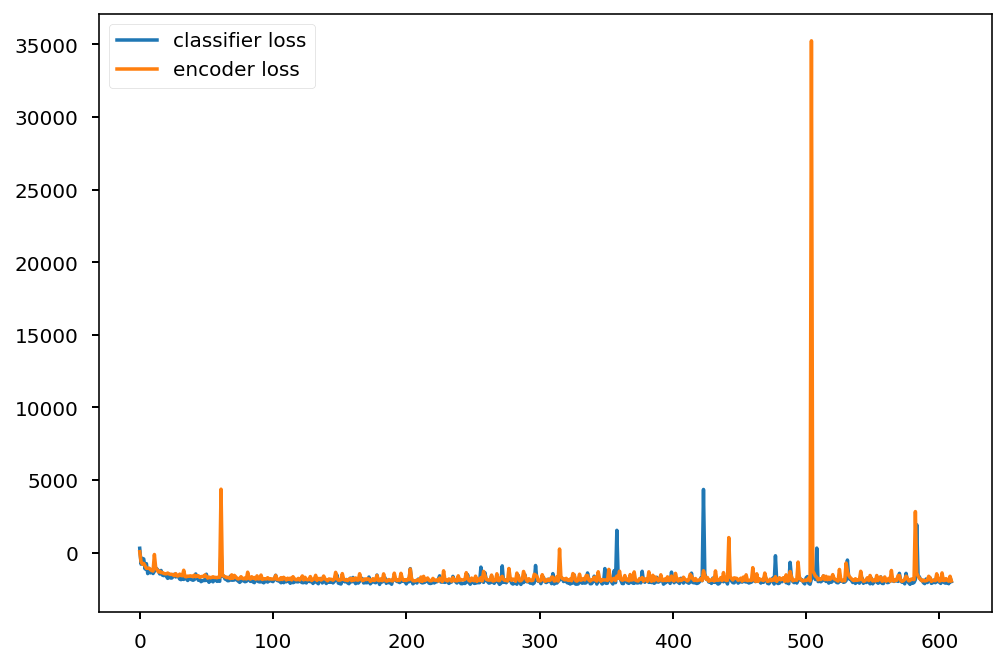

In [27]:
plt.plot(np.array(classifier_losses, dtype=np.float32), label="classifier loss")
plt.plot(np.array(encoder_losses, dtype=np.float32), label="encoder loss")
plt.legend()
plt.show()

In [28]:
# TODO:
# Change plotting functions
# Read paper to tune "temperature" param
# Tune lr decay
# Also remember this is waveform only!
# Write custom network architectures for all the models!!!

In [29]:
def plot_random_reconstruction(full_dataset, n_neurons=1, label=None, use_label_info=False):
    """
    Plots a random neuron from the dataset. Optionally, can specify a label
    """
    if label is not None:
        if label in CORRESPONDENCE:
            mask = full_dataset[:, 0] == label
            full_dataset = full_dataset[mask, :]
        elif label in LABELLING:
            mask = full_dataset[:, 0] == LABELLING[label]
            full_dataset = full_dataset[mask, :]
        else:
            return "Invalid label"

    if n_neurons > full_dataset.shape[0]:
        print(
            f"Only {full_dataset.shape[0]} neurons to plot with the provided parameter choice"
        )
        n_neurons = full_dataset.shape[0]

    idx = np.random.choice(range(full_dataset.shape[0]), n_neurons, replace=False)
    for i in idx:
        fig, axs = plt.subplots(2, 4, figsize=(14, 6), constrained_layout=True)
        fig.suptitle(
            r"$\bf{"
            + CORRESPONDENCE[full_dataset[i, 0]]
            + "}$ - "
            + "Dataset: "
            + dataset.info[i]
        )
        wf_original = full_dataset[i, 1 : N_CHANNELS * CENTRAL_RANGE + 1].reshape(
            N_CHANNELS, CENTRAL_RANGE
        )
        acg_original = full_dataset[i, N_CHANNELS * CENTRAL_RANGE + 1 :]

        axs[0, 0].imshow(wf_original, interpolation="nearest", aspect="auto")
        rect = patches.Rectangle(
            (0, N_CHANNELS // 2 - 0.5),
            CENTRAL_RANGE - 1,
            1,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        axs[0, 0].add_patch(rect)
        axs[0, 0].set_title("Original raw waveform across channels")

        n_lines = wf_original.shape[0]
        x = range(wf_original.shape[1])
        linewidth = 4
        for j, row in enumerate(wf_original):
            if j == 5:
                line = row + (n_lines - j)
                axs[0, 1].plot(
                    x, line, lw=linewidth, c="red", alpha=1, zorder=j / n_lines
                )
            # elif i % 2 == 0:
            #     continue
            else:
                line = row + (n_lines - j)
                axs[0, 1].plot(
                    x, line, lw=linewidth, c="grey", alpha=1, zorder=j / n_lines
                )
        axs[0, 1].set_title("Original Raw waveforms")
        axs[0, 1].set_yticks([])

        axs[0, 2].plot(wf_original[N_CHANNELS // 2, :])
        axs[0, 2].set_title("Original Peak channel waveform")

        axs[0, 3].plot(np.concatenate((acg_original[::-1], acg_original)))
        axs[0, 3].set_title("Original autocorrelogram")
        
        # Getting this y scale for later:
        y_min, y_max = axs[0, 3].get_ylim()

        # Can decide to use labels (if present) in the generative process
        if use_label_info and (full_dataset[i, 0] in LABELLING.values()) and full_dataset[i, 0] != -1:
            this_label = datasets.one_hot(full_dataset[i, 0])
        else:
            this_label = None
        
        with torch.no_grad():
            network_input = torch.Tensor(full_dataset[i, 1:].reshape(1, -1).astype(np.float32))
            all_reconstructed, all_reconstructed_stddev = ss_vae.model(network_input, this_label)
            all_reconstructed = all_reconstructed.detach().numpy().squeeze()
            all_reconstructed_stddev = all_reconstructed_stddev.detach().numpy().squeeze()
            wf_reconstructed = all_reconstructed[: N_CHANNELS * CENTRAL_RANGE].reshape(
                N_CHANNELS, CENTRAL_RANGE
            )
            reconstructed_acg = all_reconstructed[N_CHANNELS * CENTRAL_RANGE :]
            wf_reconstructed_stddev = all_reconstructed_stddev[
                : N_CHANNELS * CENTRAL_RANGE
            ].reshape(N_CHANNELS, CENTRAL_RANGE)
            acg_reconstructed_stddev = all_reconstructed_stddev[
                N_CHANNELS * CENTRAL_RANGE :
            ]

        axs[1, 0].imshow(wf_reconstructed, interpolation="nearest", aspect="auto")
        rect = patches.Rectangle(
            (0, N_CHANNELS // 2 - 0.5),
            CENTRAL_RANGE - 1,
            1,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        axs[1, 0].add_patch(rect)
        axs[1, 0].set_title("Reconstructed raw waveform across channels")

        n_lines = wf_reconstructed.shape[0]
        x = range(wf_reconstructed.shape[1])
        linewidth = 4
        for i, row in enumerate(wf_reconstructed):
            if i == 5:
                line = row + (n_lines - i)
                axs[1, 1].plot(
                    x, line, lw=linewidth, c="red", alpha=1, zorder=i / n_lines
                )
            # elif i % 2 == 0:
            #     continue
            else:
                line = row + (n_lines - i)
                axs[1, 1].plot(
                    x, line, lw=linewidth, c="grey", alpha=1, zorder=i / n_lines
                )
        axs[1, 1].set_title("Reconstructed Raw waveforms")
        axs[1, 1].set_yticks([])

        axs[1, 2].plot(wf_reconstructed[N_CHANNELS // 2, :])
        axs[1, 2].set_title("Reconstructed Peak channel waveform")
        axs[1, 2].fill_between(
            range(wf_reconstructed.shape[1]),
            wf_reconstructed[N_CHANNELS // 2, :]
            + wf_reconstructed_stddev[N_CHANNELS // 2, :],
            wf_reconstructed[N_CHANNELS // 2, :]
            - wf_reconstructed_stddev[N_CHANNELS // 2, :],
            facecolor="blue",
            alpha=0.2,
        )

        full_reconstructed_acg = np.concatenate((reconstructed_acg[::-1], reconstructed_acg))
        full_reconstructed_acg_stdev = np.concatenate((acg_reconstructed_stddev[::-1], acg_reconstructed_stddev))
        axs[1, 3].plot(full_reconstructed_acg)
        axs[1, 3].set_title("Reconstructed autocorrelogram")
        axs[1, 3].fill_between(
            range(full_reconstructed_acg.shape[0]),
            full_reconstructed_acg + full_reconstructed_acg_stdev,
            full_reconstructed_acg - full_reconstructed_acg_stdev,
            alpha=0.2
        )
        axs[1, 3].set_ylim(y_min, y_max)

        plt.show()


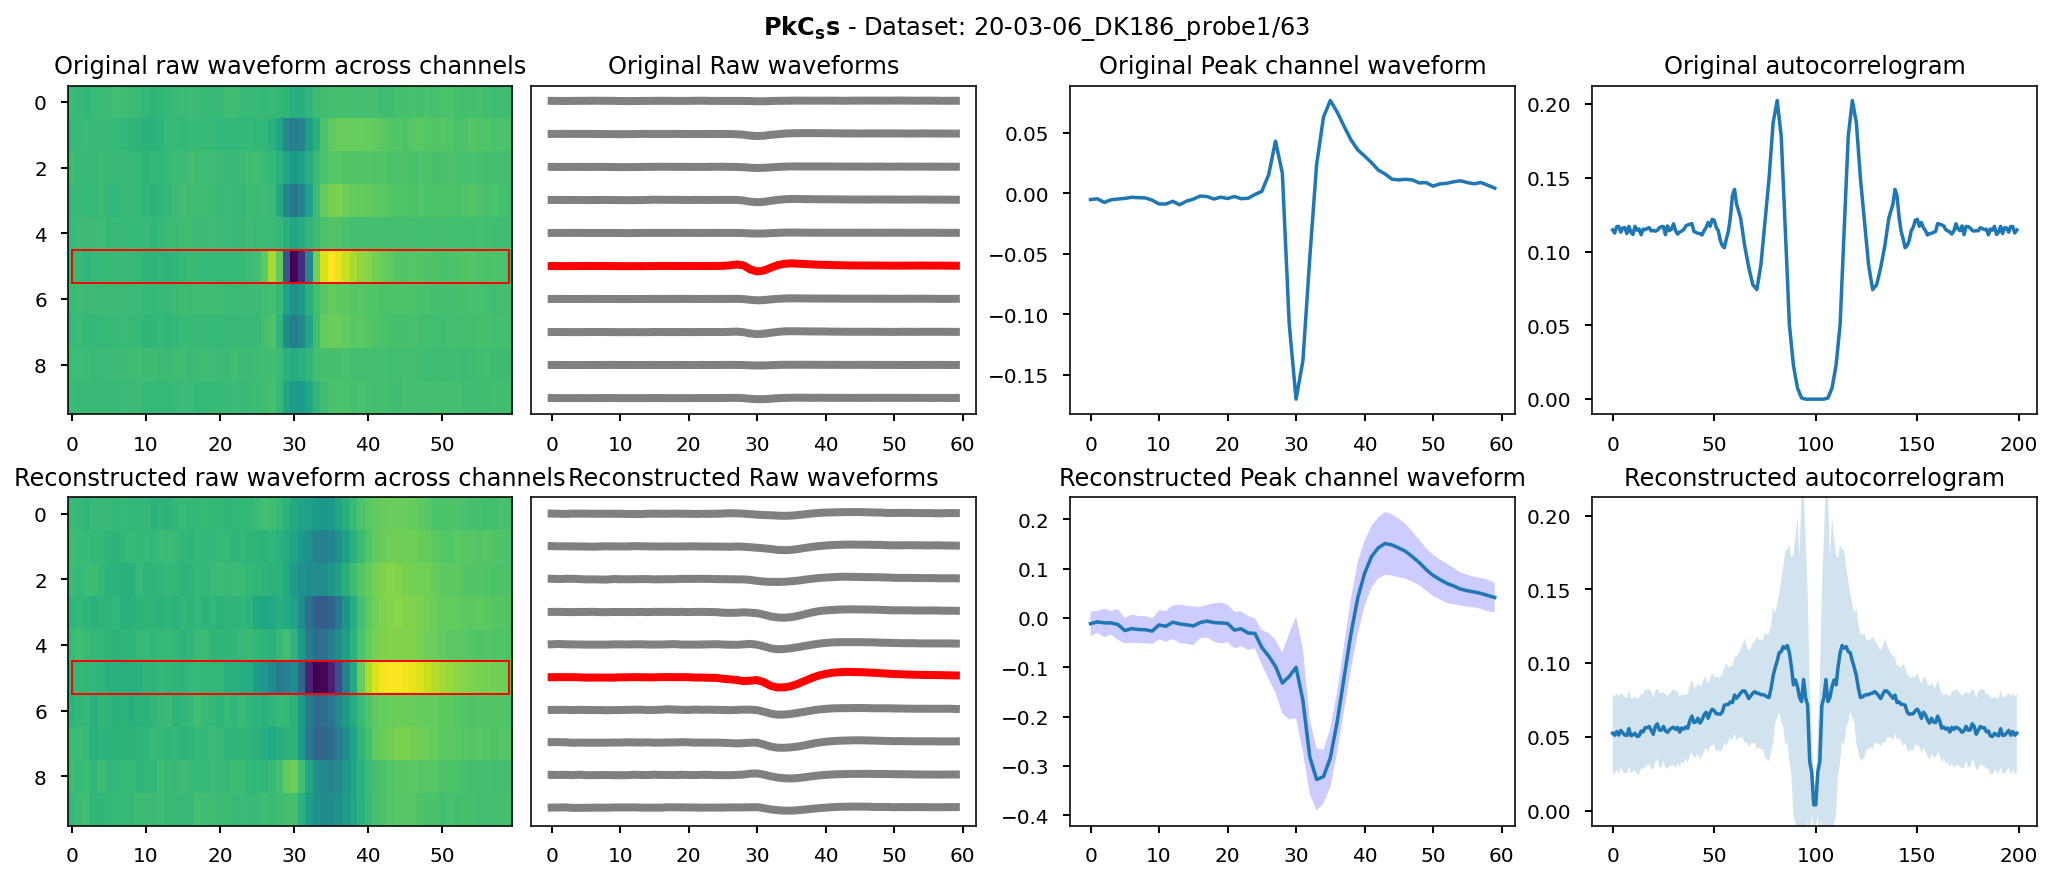

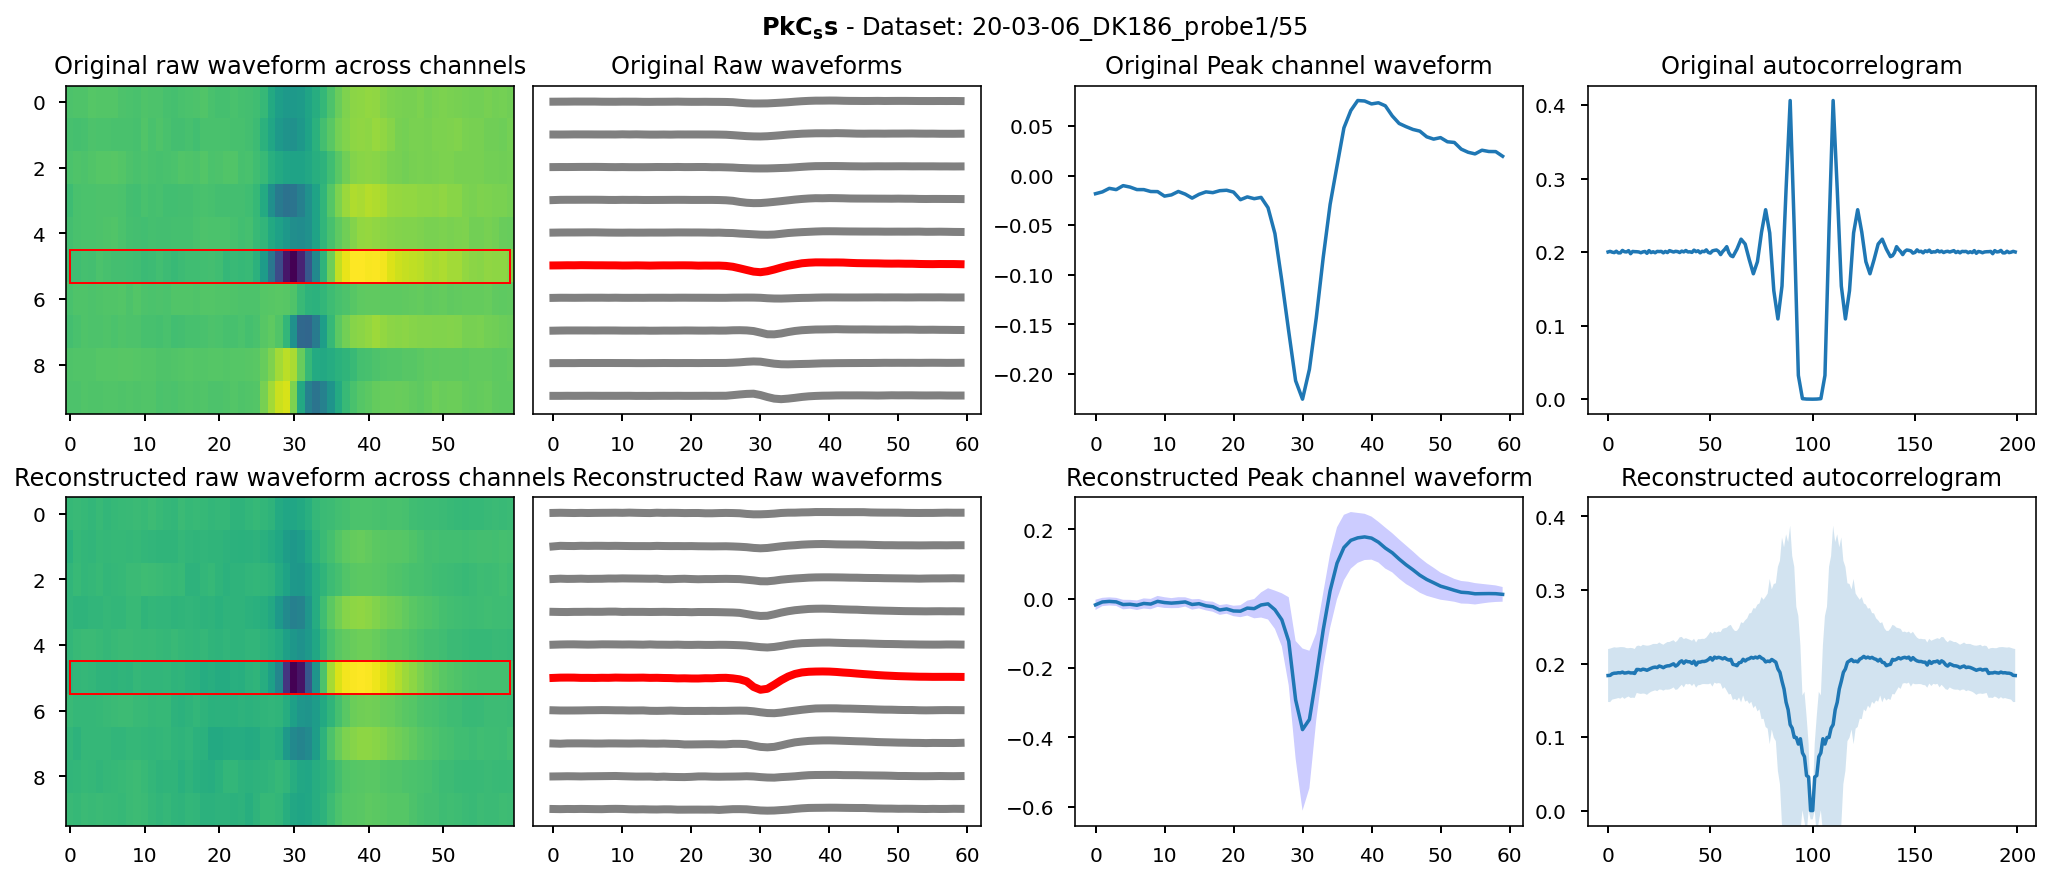

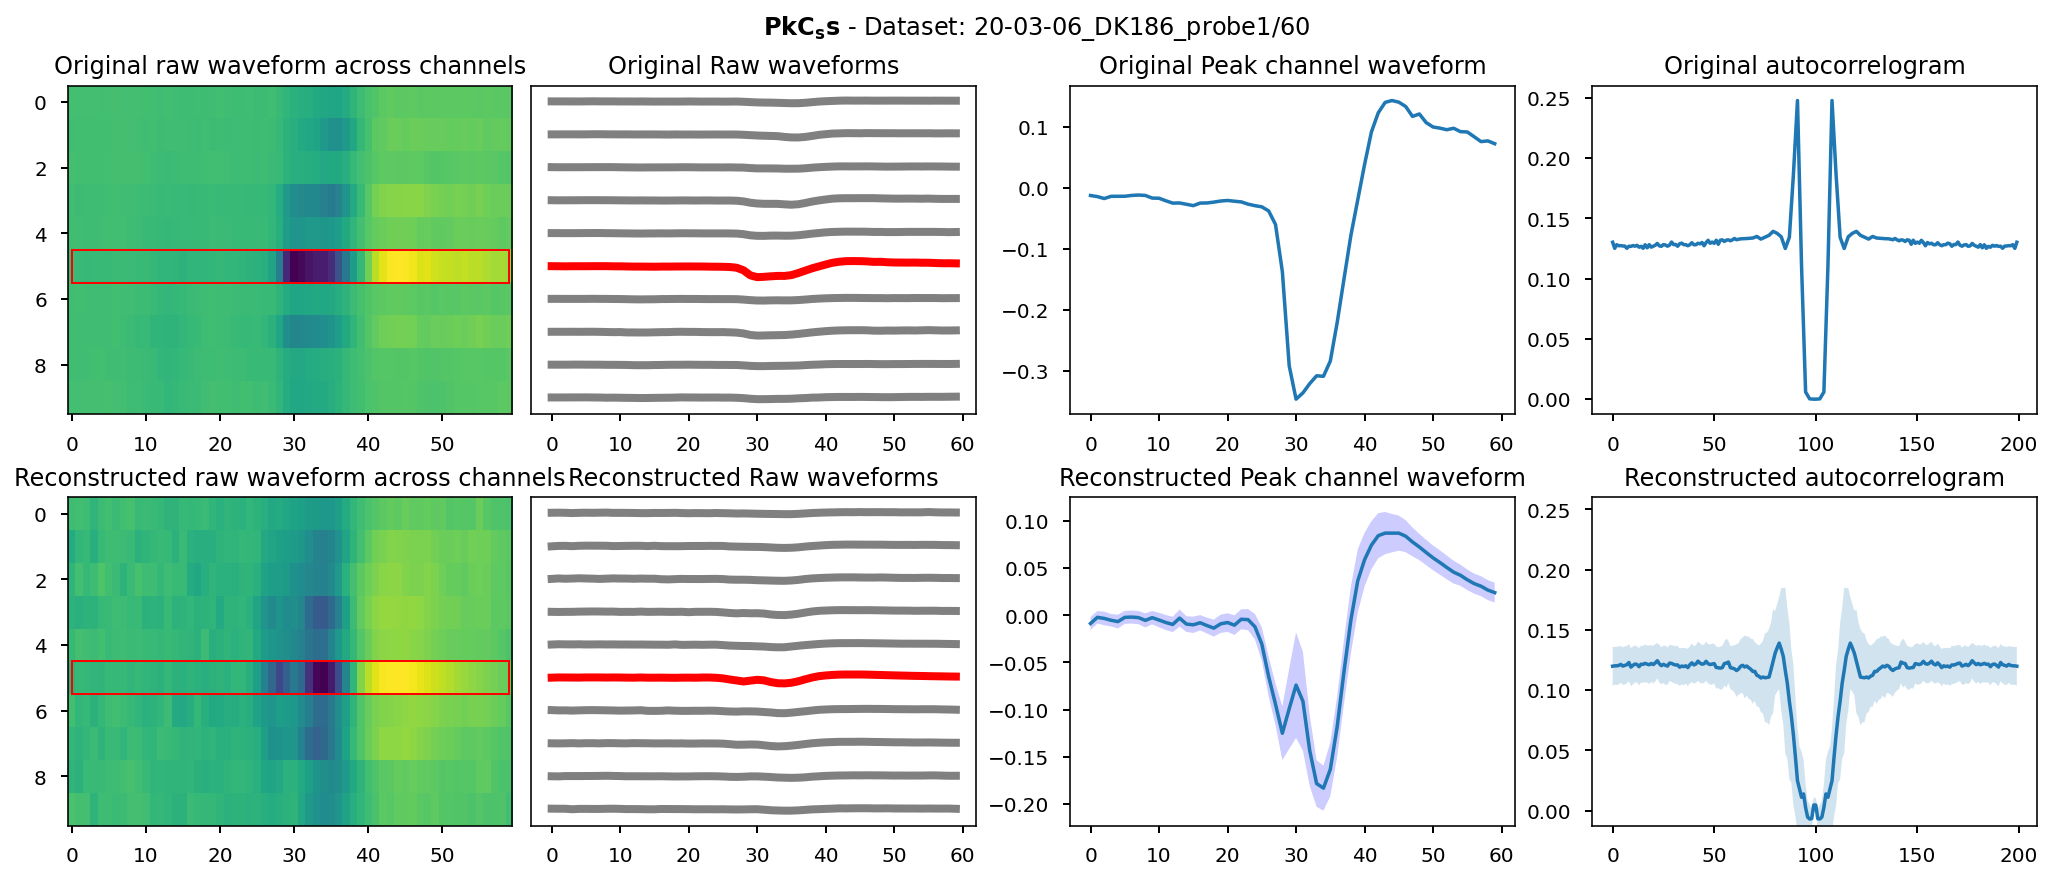

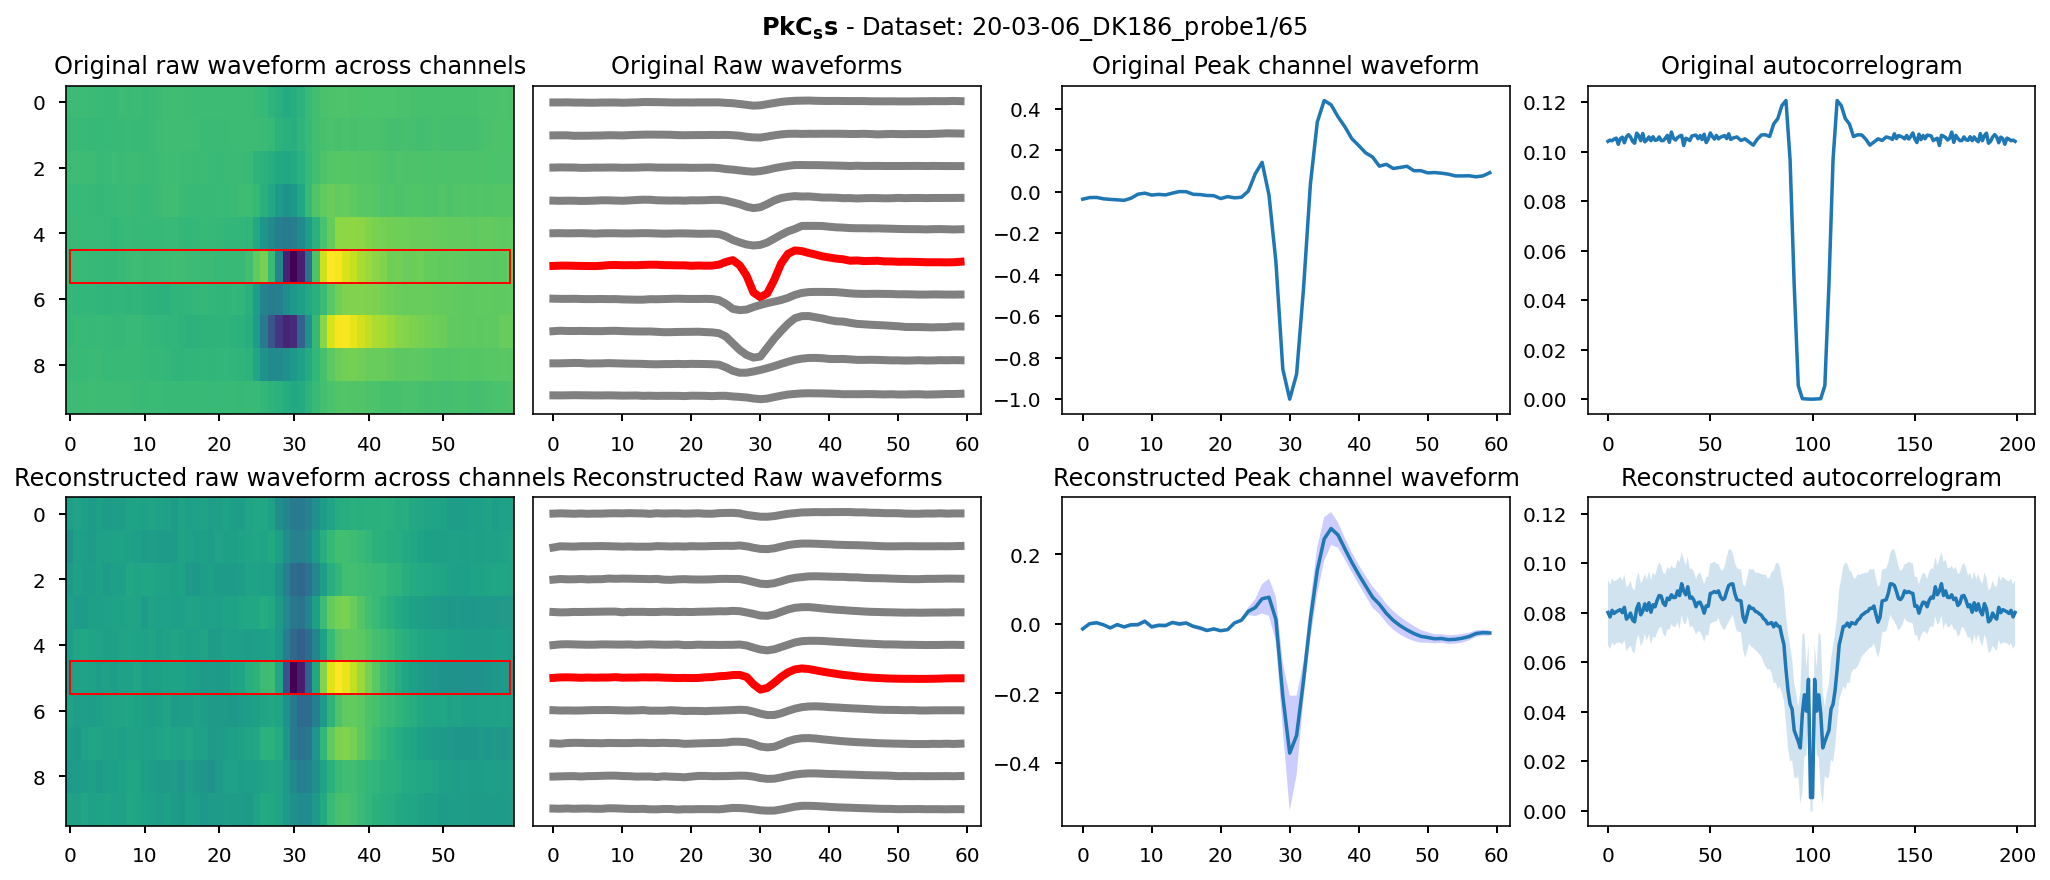

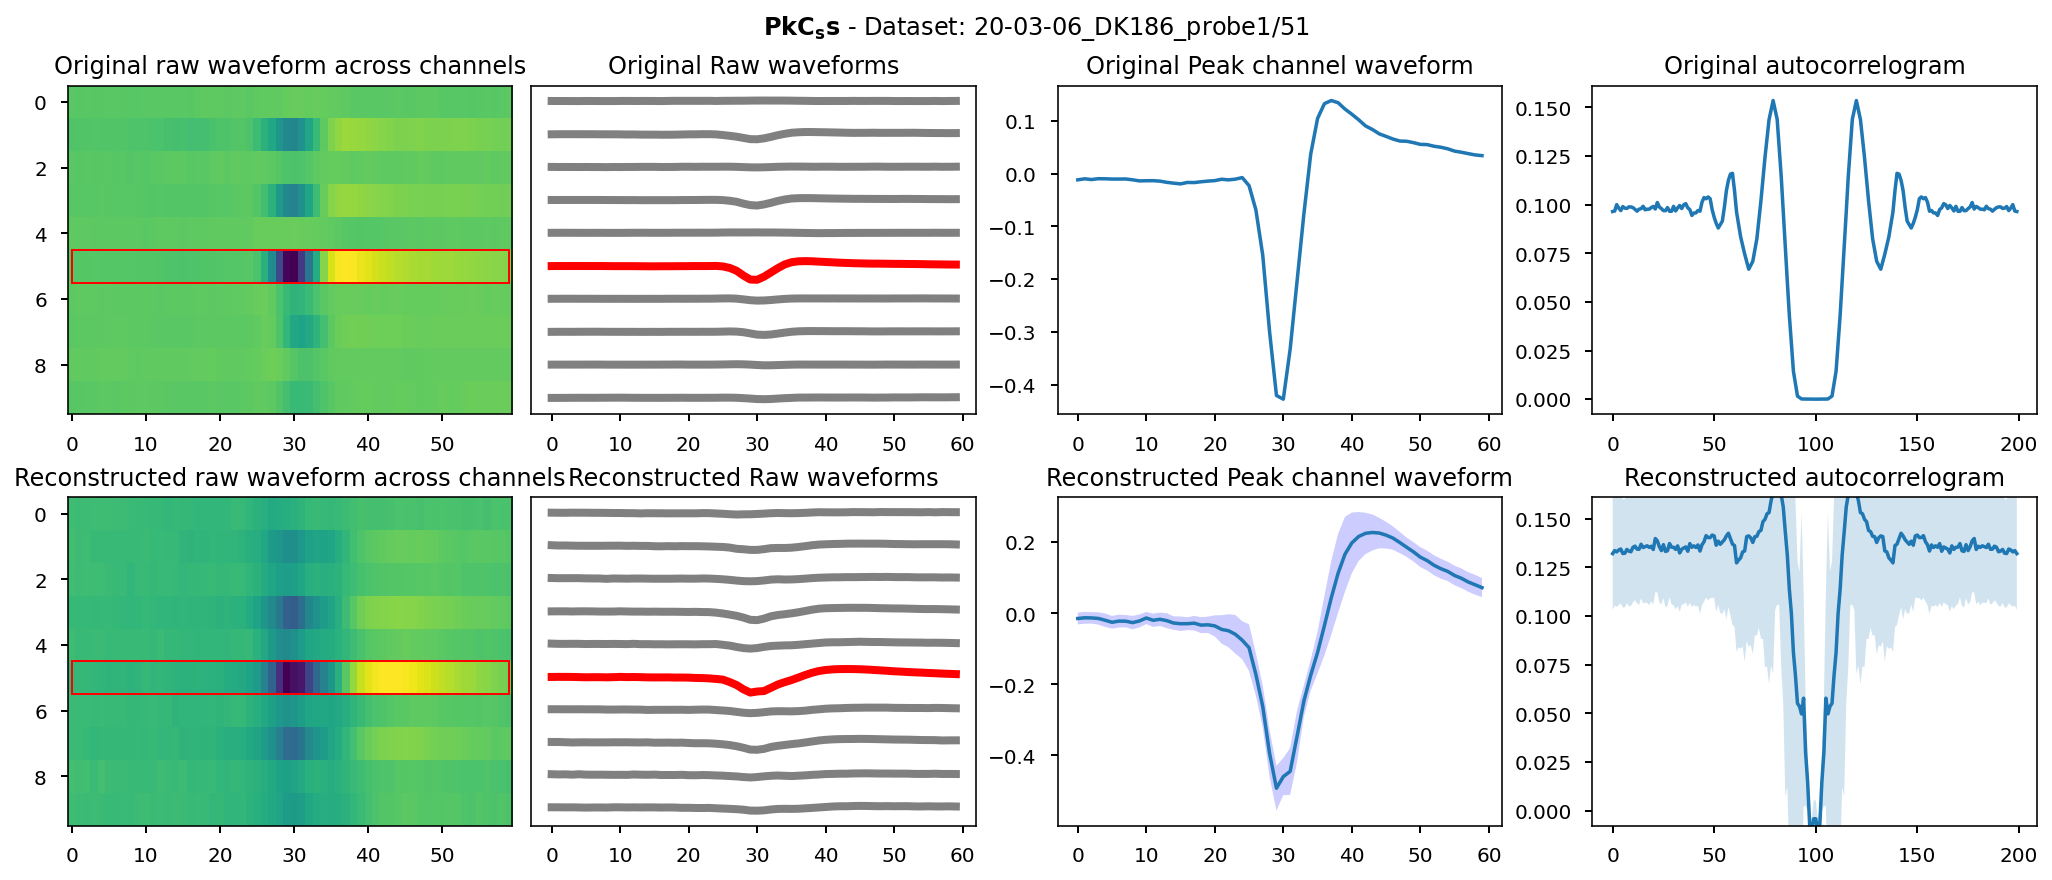

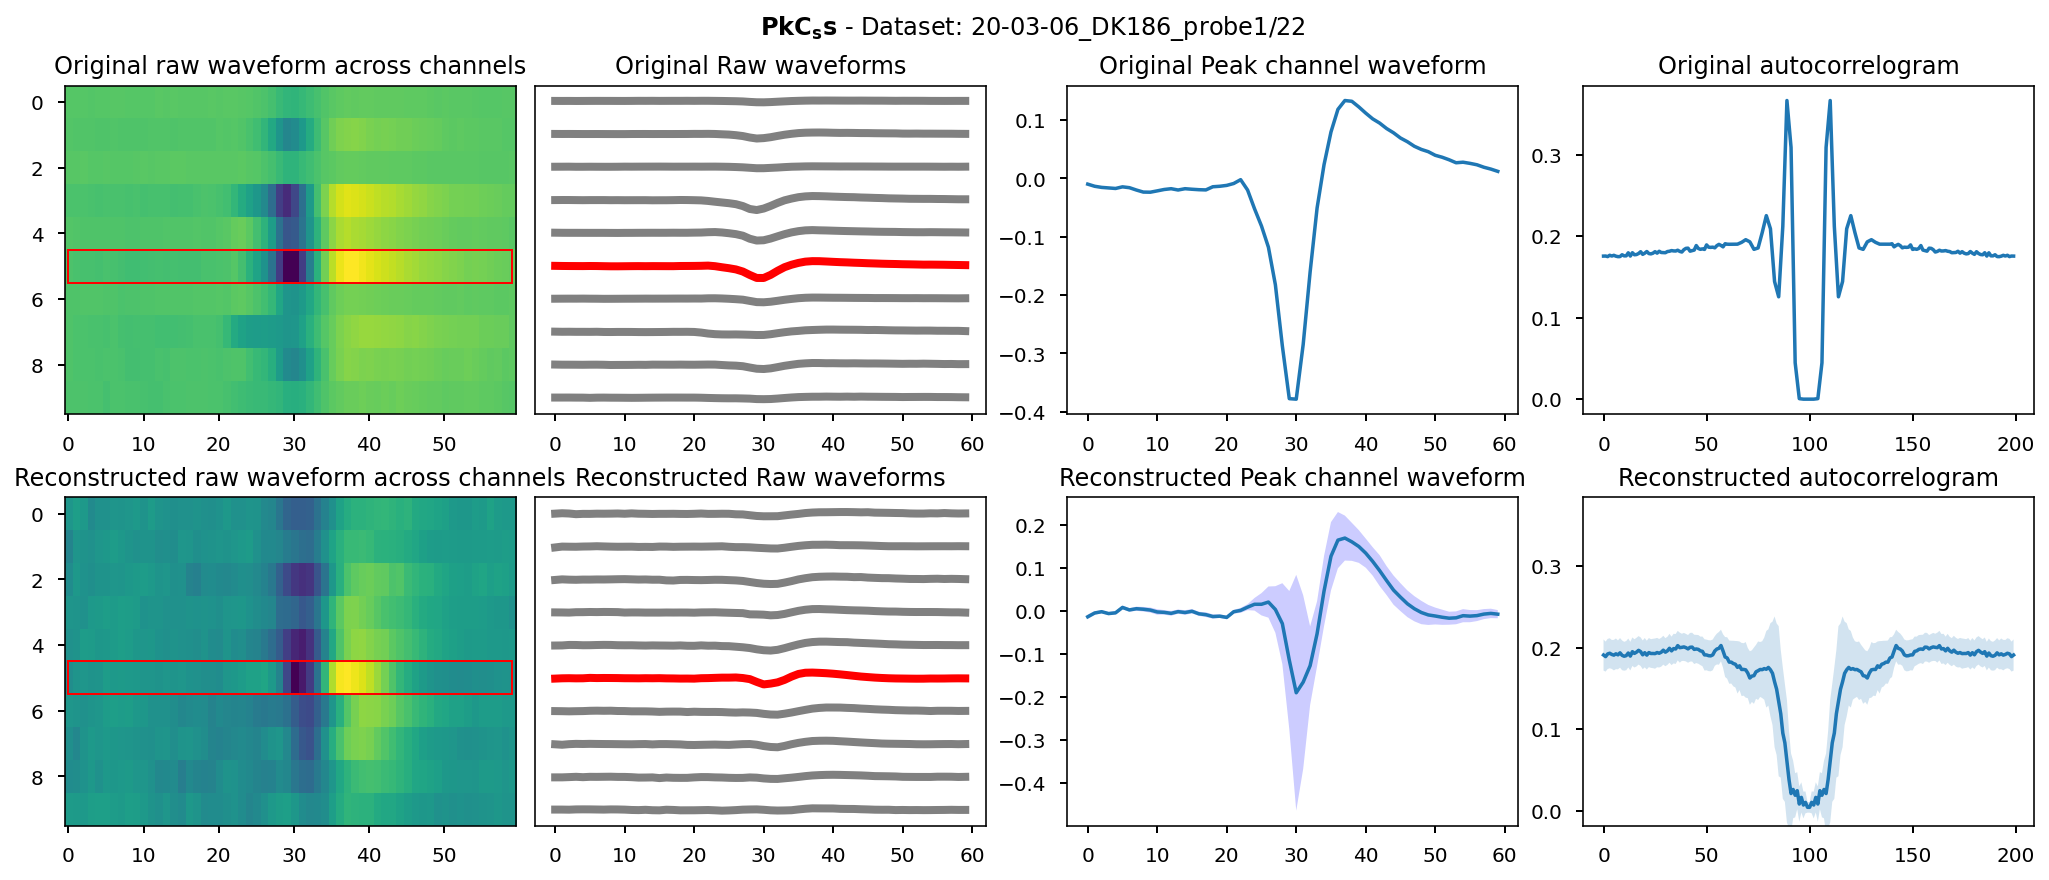

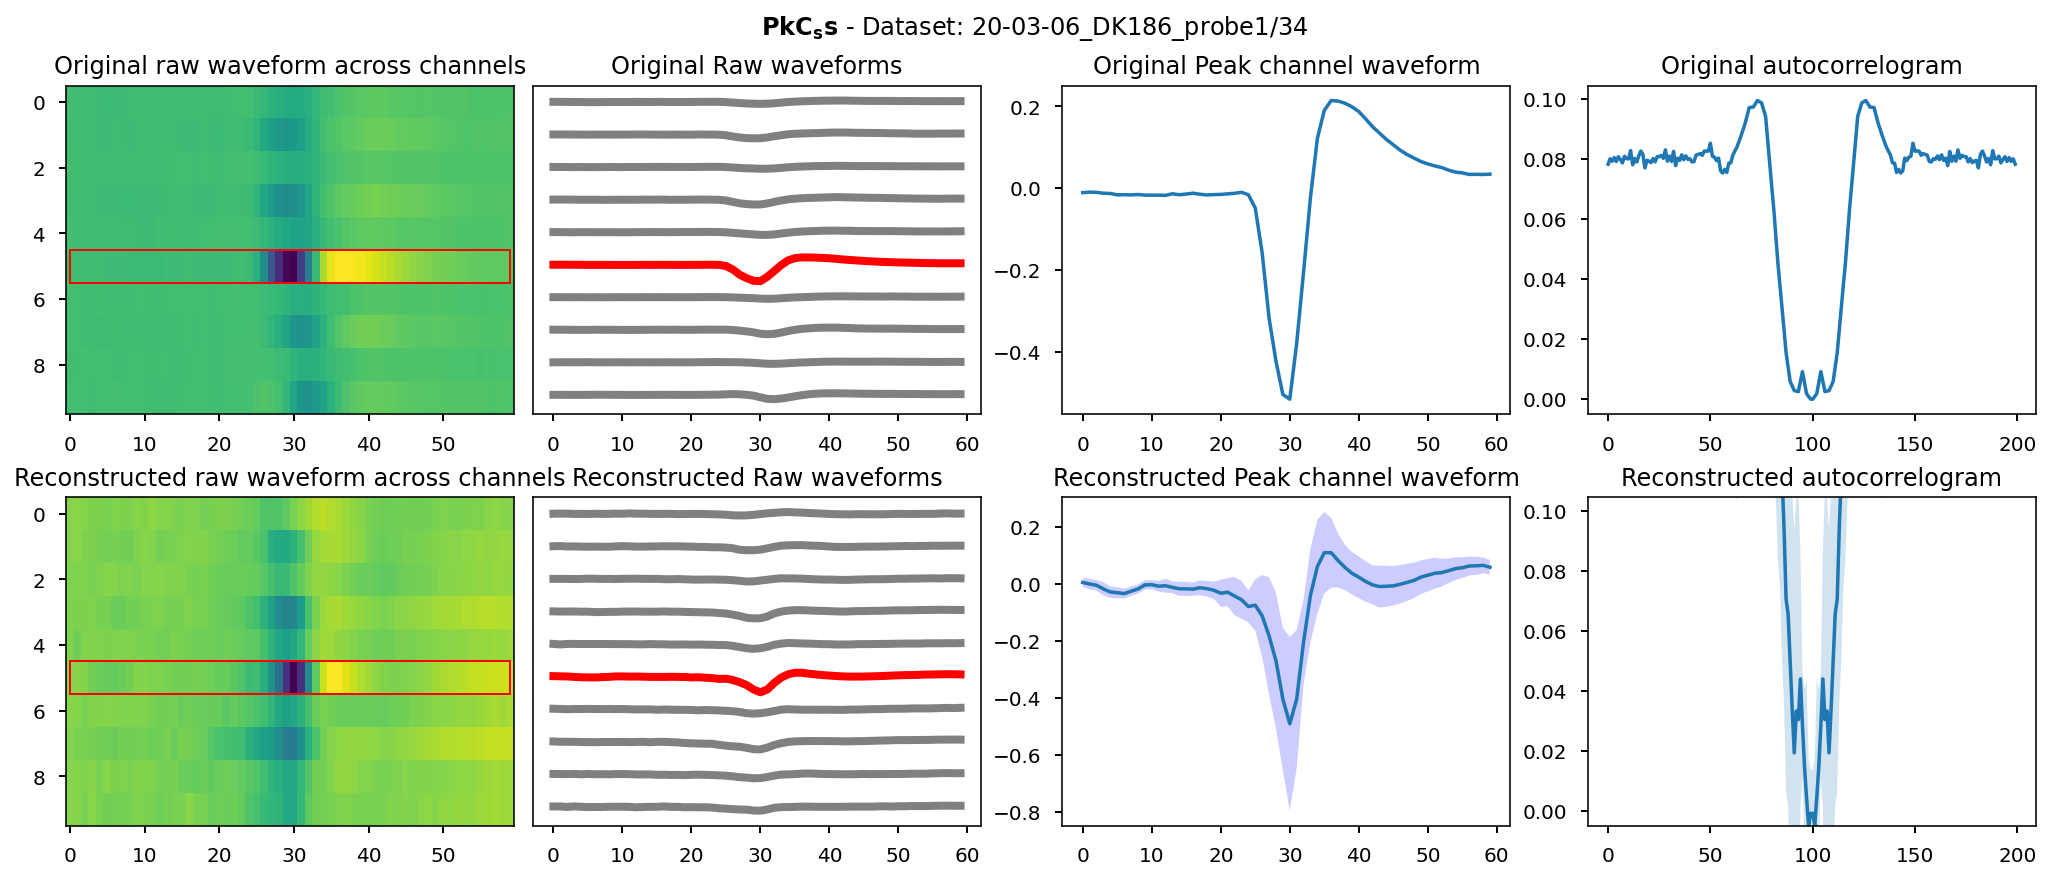

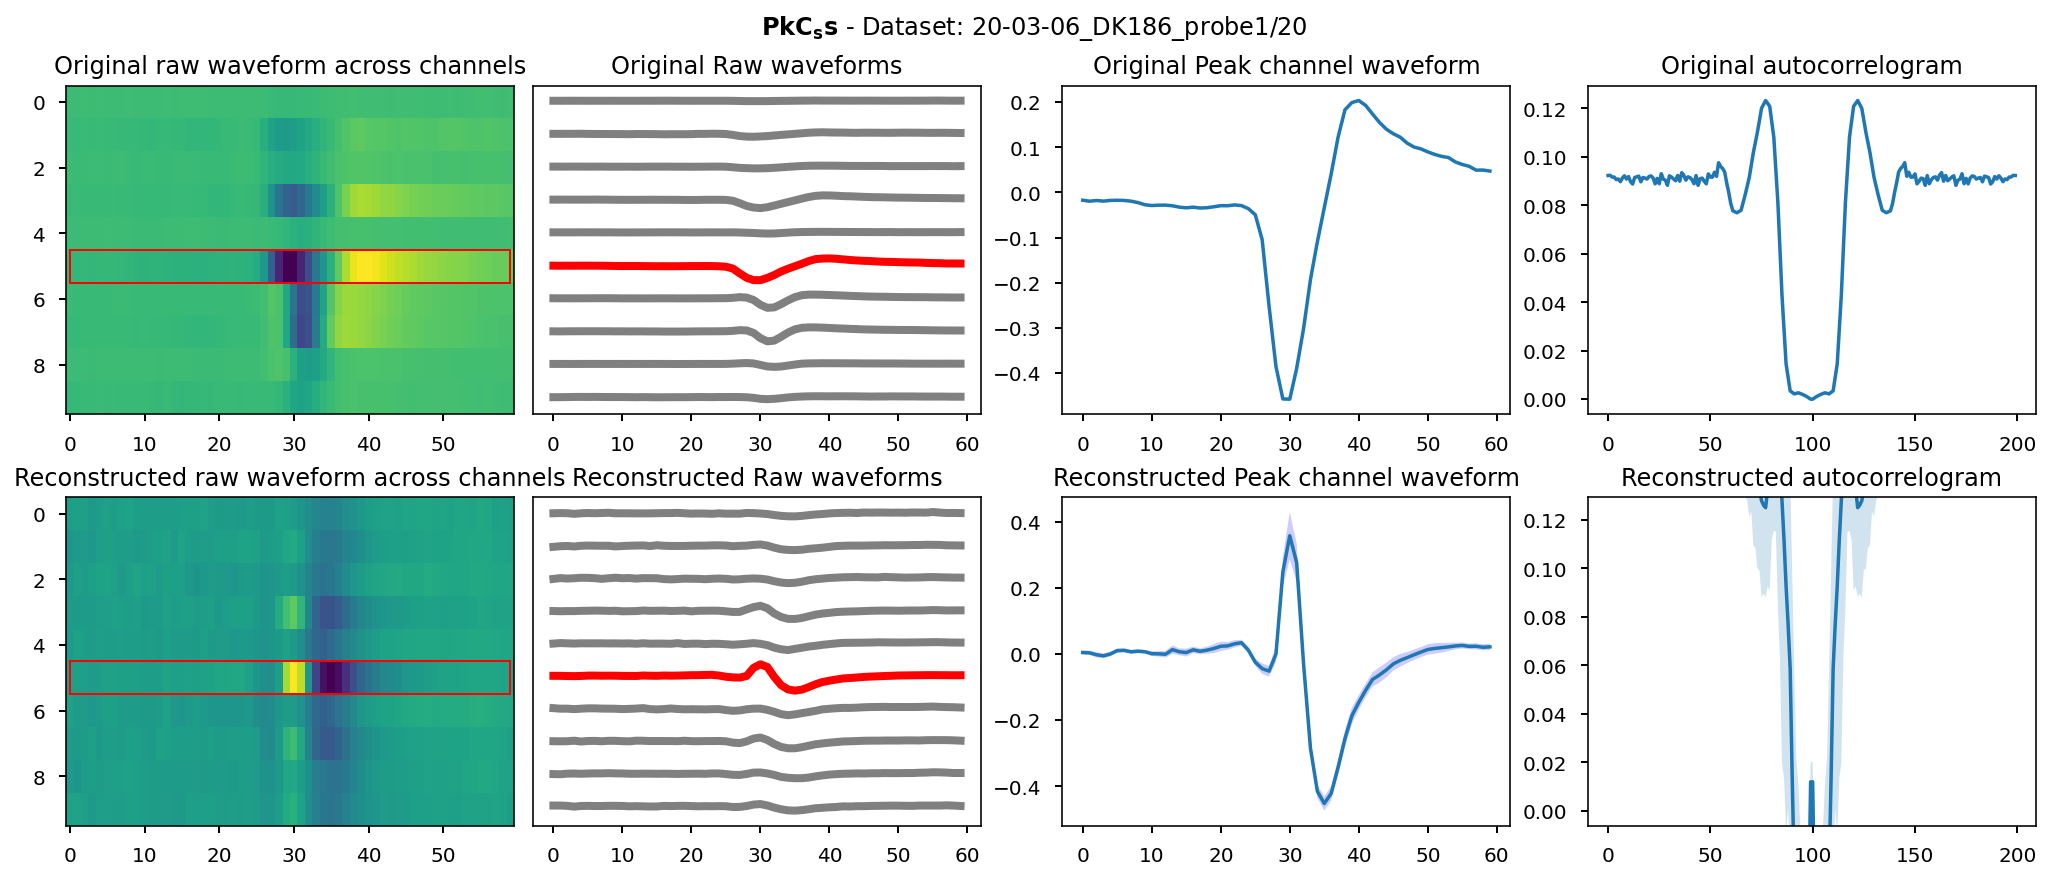

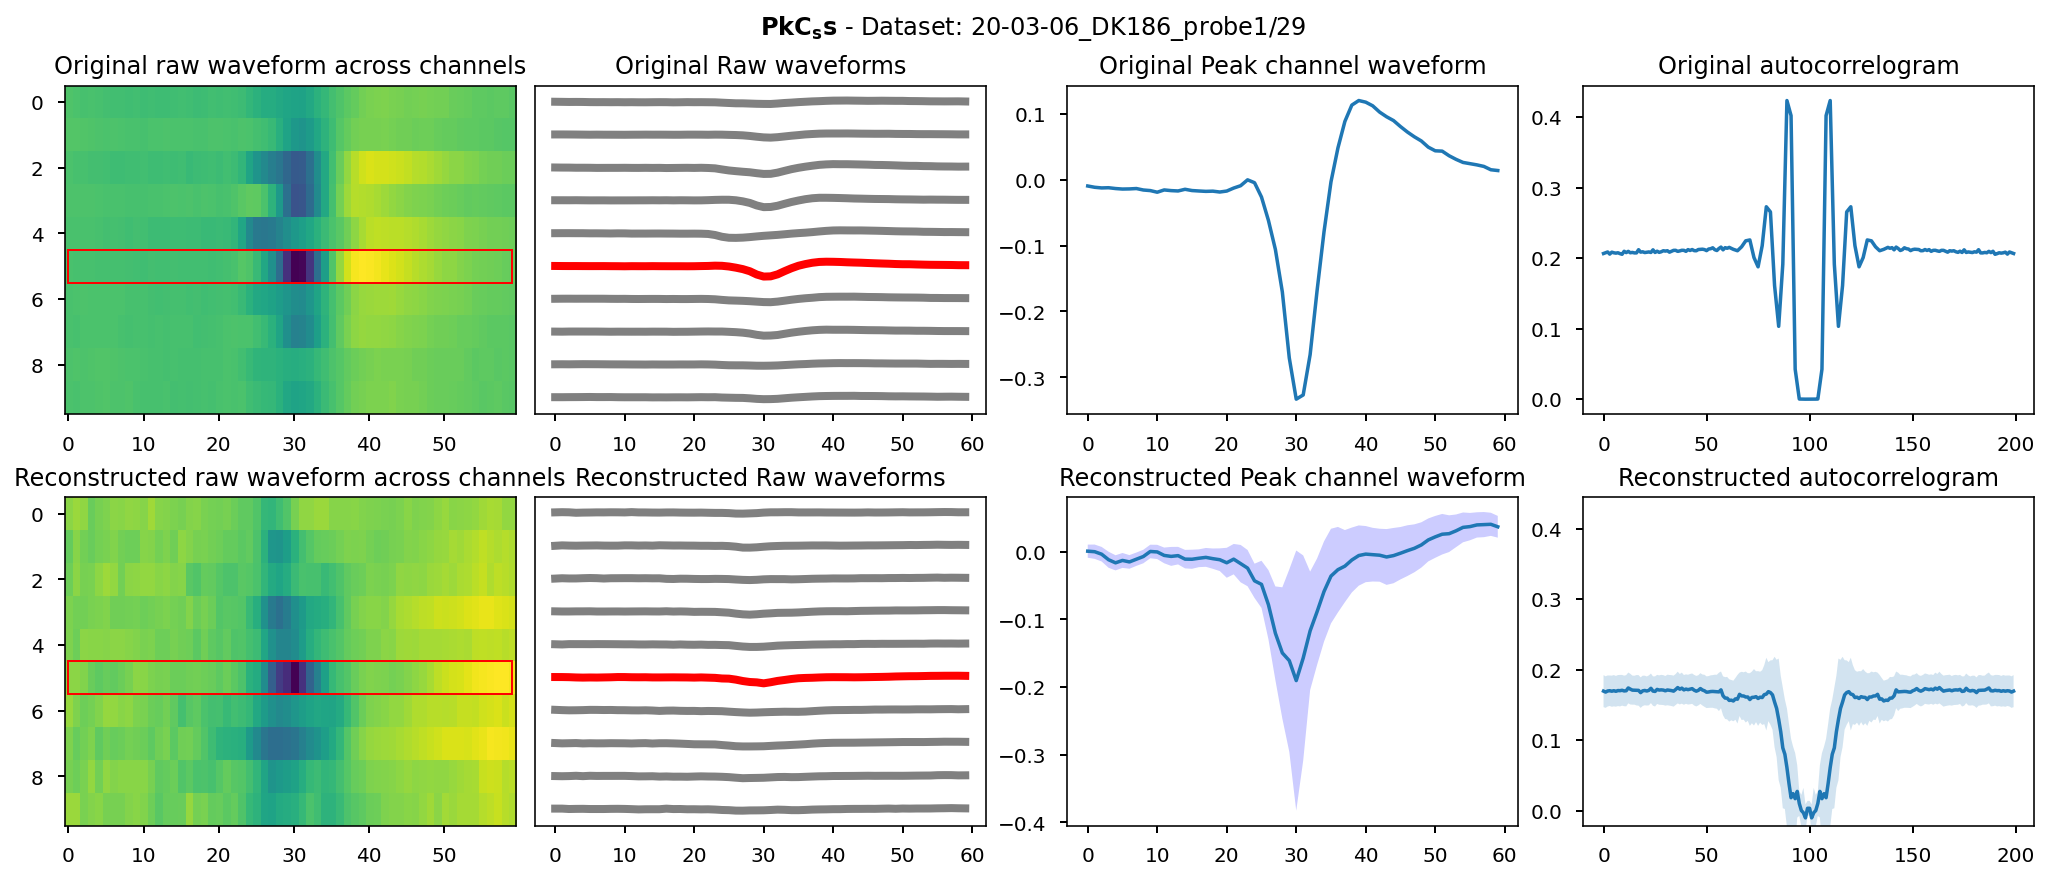

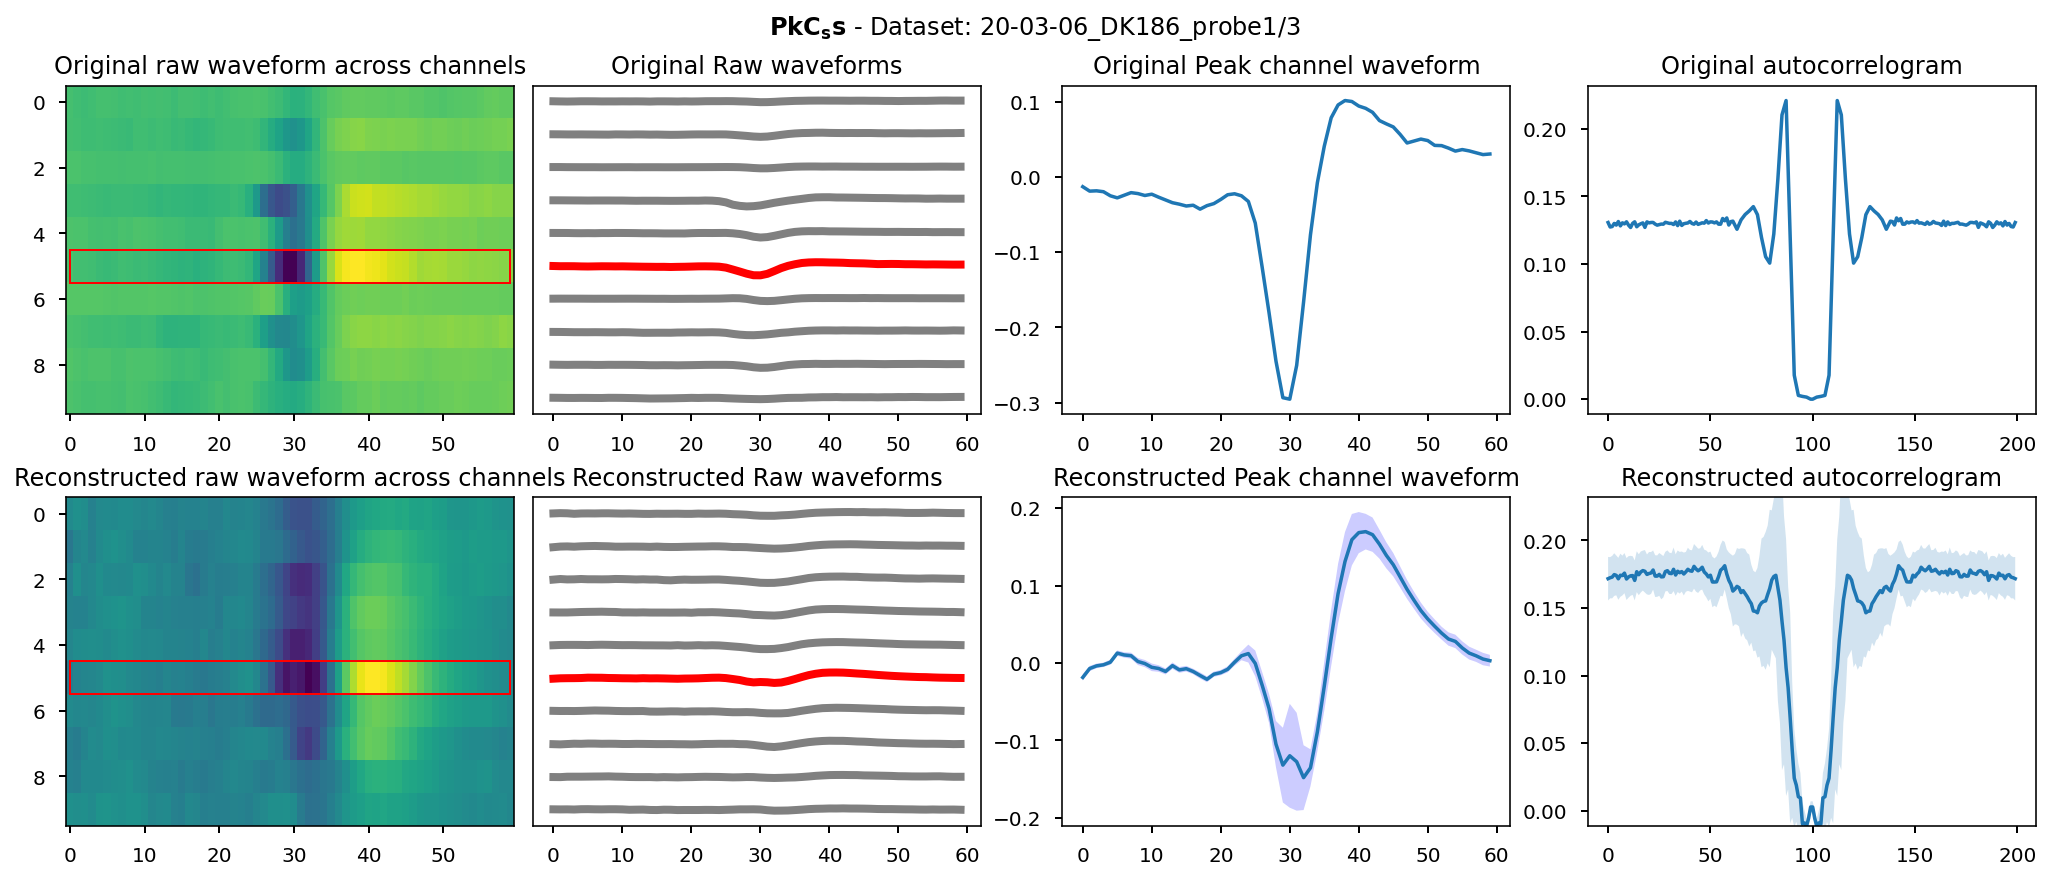

In [30]:
plotting_dataset = np.concatenate((dataset.targets[:, None], dataset.full_dataset), axis = 1)
plot_random_reconstruction(plotting_dataset, n_neurons=10, label="PkC_ss", use_label_info=True)

# Getting percentages outputs

In [ ]:
predictions = []
for i, datapoint in enumerate(full_dataset):
    with torch.no_grad():
        output = ss_vae.encoder_y(torch.tensor(full_dataset[0], dtype=torch.float32).reshape(1, -1))
    predictions.append(output.argmax().item())

In [ ]:
pd.Series(predictions).replace(CORRESPONDENCE).value_counts()